### GEDI vs FIA data

In [19]:
import pandas as pd
import geopandas as gpd
import numpy as np

from gwr import GWR

from sel_bw import Sel_BW
from scipy import stats
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

scaler = StandardScaler()
%matplotlib inline

df = pd.read_csv('./data/gedi_fia_sorted.csv').sort_values(by='GEOID').reset_index(drop=True)
gdf = gpd.read_file('./data/GEDI_FIA_AGBD_HEX.gpkg')

In [2]:
# df.head()

In [3]:
gdf.head()

,EMAP_HEX,area_ha,v0_l4b_mean,v0_l4b_mean_se,fia_mean,fia_mean_se,fia_pf,geometry
0,302.0,3536.497891,44.001065,1.741175,60.357443,0.000000,1.000000,"MULTIPOLYGON (((-6462658.04 5167015.644, -6462..."
1,402.0,31585.418344,66.993306,1.378478,42.720032,14.443391,0.479875,"MULTIPOLYGON (((-6474249.532 5187985.446, -647..."
2,403.0,56707.037443,62.833595,1.322995,116.444719,11.278149,0.877214,"MULTIPOLYGON (((-6469090.239 5158423.909, -646..."
3,404.0,14189.174500,70.263095,1.725334,20.461058,13.249689,0.176074,"MULTIPOLYGON (((-6490646.809 5147663.392, -649..."
4,419.0,2008.140769,64.352575,36.619720,93.476892,0.000000,0.789038,"MULTIPOLYGON (((-6758395.431 4835822.536, -675..."


In [4]:
# gdf.boundary.plot(figsize=(45, 40))

In [5]:
gdf['lon'] = gdf['geometry'].centroid.x
gdf['lat'] = gdf['geometry'].centroid.y
# gdf['id'] = gdf['id'].astype('int') 
gdf.head()

,EMAP_HEX,area_ha,v0_l4b_mean,v0_l4b_mean_se,fia_mean,fia_mean_se,fia_pf,geometry,lon,lat
0,302.0,3536.497891,44.001065,1.741175,60.357443,0.000000,1.000000,"MULTIPOLYGON (((-6462658.04 5167015.644, -6462...",-6.465926e+06,5.162728e+06
1,402.0,31585.418344,66.993306,1.378478,42.720032,14.443391,0.479875,"MULTIPOLYGON (((-6474249.532 5187985.446, -647...",-6.475582e+06,5.175395e+06
2,403.0,56707.037443,62.833595,1.322995,116.444719,11.278149,0.877214,"MULTIPOLYGON (((-6469090.239 5158423.909, -646...",-6.486918e+06,5.159700e+06
3,404.0,14189.174500,70.263095,1.725334,20.461058,13.249689,0.176074,"MULTIPOLYGON (((-6490646.809 5147663.392, -649...",-6.508361e+06,5.145301e+06
4,419.0,2008.140769,64.352575,36.619720,93.476892,0.000000,0.789038,"MULTIPOLYGON (((-6758395.431 4835822.536, -675...",-6.755211e+06,4.836577e+06


In [6]:
gdf.isnull().sum()

EMAP_HEX          0
area_ha           0
v0_l4b_mean       0
v0_l4b_mean_se    0
fia_mean          0
fia_mean_se       0
fia_pf            0
geometry          0
lon               0
lat               0
dtype: int64

In [7]:
# import geopandas as gpd
# from geopandas import GeoDataFrame

# counties = gpd.read_file('https://cdn.jsdelivr.net/npm/us-atlas@3/counties-10m.json')\
#                                                                             .sort_values(by='id').reset_index(drop=True)

# empty = counties['geometry'].is_empty
# counties_non_empty = counties[~empty]

# counties_non_empty['lon'] = counties_non_empty['geometry'].centroid.x
# counties_non_empty['lat'] = counties_non_empty['geometry'].centroid.y
# counties_non_empty['id'] = counties_non_empty['id'].astype('int')
# counties_non_empty.head()

In [8]:
# data = df.merge(counties_non_empty, left_on='GEOID', right_on='id', how='inner')
# data.dropna(inplace=True)
# data.head()

In [9]:
# gdf = GeoDataFrame(data, crs="EPSG:4326")  # change the EPSG, see whether the result changes
# gdf.boundary.plot()

In [10]:
g_y = gdf['fia_mean'].values.reshape((-1,1))
g_X = gdf[['v0_l4b_mean']].values

# g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)
# g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

u = gdf['lon']
v = gdf['lat']

g_coords = list(zip(u,v))

### Calculate LWCC using the Old Algo

In [11]:
gwr_selector_o = Sel_BW(g_coords, g_y, g_X, lwcc=False)
gwr_bw_o = gwr_selector_o.search(bw_min=2)
print(gwr_bw_o)
gwr_results_o = GWR(g_coords, g_y, g_X, gwr_bw_o, lwcc=False).fit()
gwr_results_o.summary()

38.29
Model type                                                         Gaussian
Number of observations:                                               12550
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                        7060254.277
Log-likelihood:                                                  -57544.214
AIC:                                                             115092.429
AICc:                                                            115094.431
BIC:                                                            6941832.829
R2:                                                                   0.808
Adj. R2:                                                              0.808

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- 

In [12]:
"""Local collinearity formula implementation. Extracted from MGWR codebase, line 1092, gwr.py, __author__ = Taylor Oshan"""

# x_scaled = scaler.fit_transform(x)
# y_scaled = scaler.fit_transform(y)


x_ = np.hstack((g_X, g_y))

def corr(cov):
    invsd = np.diag(1 / np.sqrt(np.diag(cov)))
    cors = np.dot(np.dot(invsd, cov), invsd)
    return cors

corr_mat = np.ndarray(shape=(len(x_), 1))


for i in range(len(x_)):
    wi_ = gwr_results_o.model._build_wi(i, gwr_bw_o)  
    sw = np.sum(wi_)
    wi_ = wi_/sw
    corr_mat[i] = corr(np.cov(x_[:, 0], x_[:, 1], aweights=wi_))[0][1]

# corr_mat = corr_mat[~np.isnan(corr_mat)]    
corr_mat[~np.isnan(corr_mat)].mean(), corr_mat[~np.isnan(corr_mat)].min(), corr_mat[~np.isnan(corr_mat)].max()

(np.float64(0.660183964532277),
 np.float64(-0.5248306749062516),
 np.float64(0.9952237686101197))

In [13]:
gdf['gwr_calc'] = corr_mat
# corr_mat.mean(), corr_mat.min(), corr_mat.max()
# corr_mat
# gdf.join(pd.Series(corr_mat, name='corr_mat'), how='right').shape

In [14]:
gwr_selector_n = Sel_BW(g_coords, g_y, g_X, lwcc=True)
gwr_bw_n = gwr_selector_n.search(bw_min=2)
print(gwr_bw_n)
gwr_results_n = GWR(g_coords, g_y, g_X, gwr_bw_n, constant=False, lwcc=True).fit()  # using a fixed bandwidth of 200
gwr_results_n.summary()

12180.35
Model type                                                         Gaussian
Number of observations:                                               12550
Number of covariates:                                                     1

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                        7069407.475
Log-likelihood:                                                  -57552.344
AIC:                                                             115106.689
AICc:                                                            115108.690
BIC:                                                            6950976.589
R2:                                                                   0.808
Adj. R2:                                                              0.808

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- --------

In [15]:
gdf['new_algo_params'] = gwr_results_n.params


In [16]:
gdf['gwr_calc'].describe()

count    12531.000000
mean         0.660184
std          0.258409
min         -0.524831
25%          0.527820
50%          0.729699
75%          0.858169
max          0.995224
Name: gwr_calc, dtype: float64

In [17]:
from utils import compare_stacked

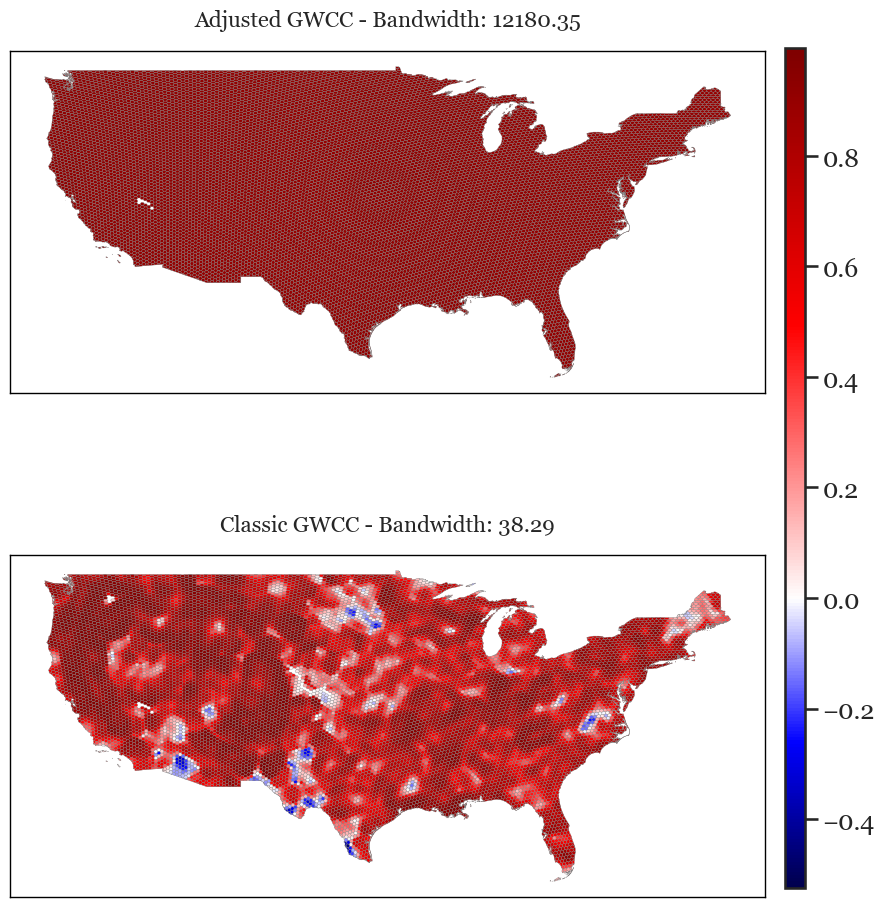

In [18]:
compare_stacked(gdf, 'new_algo_params', 'gwr_calc', gwr_bw_n, gwr_bw_o)

In [17]:
corr = []

for i in range(len(g_X)):
    wi = gwr_results_o.model._build_wi(i, gwr_bw_o).reshape(-1,1)
    xw = g_X*wi
    yw = g_y*wi
    corr_coef, _ = stats.pearsonr(xw.flatten(), yw.flatten())
    corr.append(corr_coef)



In [18]:
pd.Series(corr).mean()

0.903782566458249

In [20]:
# pd.Series(corr).isna().any().sum()xx

In [46]:
def compare_stacked(data, var1, var2, savefig=None):
    """
    Improved visualization for comparing two coefficient surfaces with Georgia-serif titles.
    """
    import matplotlib.pyplot as plt
    import geopandas as gp
    import numpy as np
    import seaborn as sns

    # ---------------------------------
    # Apply Seaborn theme with Georgia
    # ---------------------------------
    sns.set_theme(
        style='white',
        context='talk',
        rc={
            'font.family': 'serif',
            'font.serif': ['Georgia'],
            'font.size': 13,
            'axes.titlesize': 16,
        }
    )
    sns.set_palette('bright')

    # ---------------------------------
    # Figure setup
    # ---------------------------------
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))
    ax0, ax1 = axes

    ax0.set_title(f"Adjusted GWCC - Bandwidth: {gwr_bw_n}", pad=18)
    ax1.set_title(f"Classic GWCC - Bandwidth: {gwr_bw_o}", pad=18)

    # ---------------------------------
    # Colormap selection logic
    # ---------------------------------
    cmap = plt.cm.seismic

    improved_min = data[var1].min()
    improved_max = data[var1].max()
    classic_min = data[var2].min()
    classic_max = data[var2].max()
    vmin = np.min([improved_min, classic_min])
    vmax = np.max([improved_max, classic_max])

    # apply your smart colormap logic
    if (vmin < 0) and (vmax < 0):
        cmap = truncate_colormap(cmap, 0.0, 0.5)
    elif (vmin > 0) and (vmax > 0):
        cmap = truncate_colormap(cmap, 0.5, 1.0)
    else:
        cmap = shift_colormap(
            cmap,
            start=0.0,
            midpoint=1 - vmax / (vmax + abs(vmin)),
            stop=1.0
        )

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

    # ---------------------------------
    # Plot surfaces
    # ---------------------------------
    common_kwargs = dict(
        cmap=sm.cmap,
        vmin=vmin,
        vmax=vmax,
        edgecolor='grey',
        linewidth=0.25
    )

    data.plot(var1, ax=ax0, **common_kwargs)
    data.plot(var2, ax=ax1, **common_kwargs)

    # ---------------------------------
    # Aesthetic cleanup
    # ---------------------------------
    for ax in [ax0, ax1]:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_facecolor("white")

        # Clean, thin spines
        for spine in ax.spines.values():
            spine.set_linewidth(1.0)
            spine.set_edgecolor("black")

    # ---------------------------------
    # Colorbar
    # ---------------------------------
    fig.subplots_adjust(right=0.88)
    cax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax)
    cbar.ax.tick_params(labelsize=18)

    # ---------------------------------
    # Output
    # ---------------------------------
    if savefig is not None:
        plt.savefig(savefig, format="tiff", dpi=600, bbox_inches="tight")

    plt.show()


In [45]:
import numpy as np 

def shift_colormap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero
    Parameters
    ----------
    cmap : The matplotlib colormap to be altered
    start : Offset from lowest point in the colormap's range.
      Defaults to 0.0 (no lower ofset). Should be between
      0.0 and `midpoint`.
    midpoint : The new center of the colormap. Defaults to
      0.5 (no shift). Should be between 0.0 and 1.0. In
      general, this should be  1 - vmax/(vmax + abs(vmin))
      For example if your data range from -15.0 to +5.0 and
      you want the center of the colormap at 0.0, `midpoint`
      should be set to  1 - 5/(5 + 15)) or 0.75
    stop : Offset from highets point in the colormap's range.
      Defaults to 1.0 (no upper ofset). Should be between
      `midpoint` and 1.0.
    
    Returns
    -------
    new_cmap : A new colormap that has been shifted. 
    '''

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    # cm.unregister_cmap(name=name)
    


    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False),
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    new_cmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    
    # plt.register_cmap(cmap=new_cmap)

    return new_cmap

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    Function to truncate a colormap by selecting a subset of the original colormap's values
    Parameters
    ----------
    cmap : Mmatplotlib colormap to be altered
    minval : Minimum value of the original colormap to include in the truncated colormap
    maxval : Maximum value of the original colormap to include in the truncated colormap
    n : Number of intervals between the min and max values for the gradient of the truncated colormap
          
    Returns
    -------
    new_cmap : A new colormap that has been shifted. 
    '''

    import matplotlib as mpl

    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


In [44]:
# def compare_surfaces(data, var1, var2, savefig=None):
#     """
#     Vertical layout, SEPARATE colorbars (one per plot),
#     symmetric diverging limits when data crosses zero,
#     red-only if all positive, blue-only if all negative.
#     """

#     import matplotlib.pyplot as plt
#     import numpy as np
#     import seaborn as sns

#     # Theme -------------------------------------------------------
#     sns.set_theme(
#         style='white',
#         context='talk',
#         rc={
#             'font.family': 'serif',
#             'font.serif': ['Georgia'],
#             'font.size': 13,
#             'axes.titlesize': 16,
#         }
#     )

#     # --------------------------------------------------------------
#     # FULLY SAFE build_cmap() — guaranteed to always return (cmap, norm)
#     # --------------------------------------------------------------
#     def build_cmap(values):
#         vmin = float(np.nanmin(values))
#         vmax = float(np.nanmax(values))
#         cmap_full = plt.cm.seismic

#         # Case 1: crosses zero → symmetric
#         if vmin < 0 and vmax > 0:
#             max_abs = max(abs(vmin), abs(vmax))
#             from matplotlib.colors import TwoSlopeNorm
#             norm = TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)
#             return cmap_full, norm

#         # Case 2: all positive
#         if vmin >= 0:
#             from matplotlib.colors import Normalize
#             cmap = truncate_colormap(cmap_full, 0.5, 1.0)
#             norm = Normalize(vmin=vmin, vmax=vmax)
#             return cmap, norm

#         # Case 3: all negative
#         if vmax <= 0:
#             from matplotlib.colors import Normalize
#             cmap = truncate_colormap(cmap_full, 0.0, 0.5)
#             norm = Normalize(vmin=vmin, vmax=vmax)
#             return cmap, norm

#         # Failsafe (should never reach here)
#         from matplotlib.colors import Normalize
#         norm = Normalize(vmin=vmin, vmax=vmax)
#         return cmap_full, norm

#     # Figure -------------------------------------------------------
#     fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 13))
#     ax0, ax1 = axes

#     ax0.set_title(f"Adjusted GWCC - Bandwidth: {gwr_bw_n}", pad=18)
#     ax1.set_title(f"Classic GWCC  - Bandwidth: {gwr_bw_o}", pad=18)

#     # Build colormaps for each surface ----------------------------
#     cmap1, norm1 = build_cmap(data[var1].values)
#     cmap2, norm2 = build_cmap(data[var2].values)

#     # Plot surfaces ------------------------------------------------
#     data.plot(var1, ax=ax0, cmap=cmap1, norm=norm1, edgecolor='grey', linewidth=0.25)
#     data.plot(var2, ax=ax1, cmap=cmap2, norm=norm2, edgecolor='grey', linewidth=0.25)

#     # Cleanup -------------------------------------------------------
#     for ax in [ax0, ax1]:
#         ax.set_axis_off()
#         ax.set_facecolor("white")
#         for spine in ax.spines.values():
#             spine.set_linewidth(1.0)
#             spine.set_edgecolor("black")

#     # --------------------------------------------------------------
#     # TWO SEPARATE COLORBARS (right side of each subplot)
#     # --------------------------------------------------------------
#     fig.subplots_adjust(left=0.05, right=0.90, top=0.93, bottom=0.05, hspace=0.15)

#     # Colorbar 1 -----------------------------
#     bbox0 = ax0.get_position()
#     cax1 = fig.add_axes([
#         0.92,
#         bbox0.y0 + 0.05,
#         0.02,
#         bbox0.height - 0.10,
#     ])

#     sm1 = plt.cm.ScalarMappable(norm=norm1, cmap=cmap1)
#     sm1.set_array([])
#     cb1 = fig.colorbar(sm1, cax=cax1)
#     cb1.ax.tick_params(labelsize=14)

#     # Colorbar 2 -----------------------------
#     bbox1 = ax1.get_position()
#     cax2 = fig.add_axes([
#         0.92,
#         bbox1.y0 + 0.05,
#         0.02,
#         bbox1.height - 0.10,
#     ])

#     sm2 = plt.cm.ScalarMappable(norm=norm2, cmap=cmap2)
#     sm2.set_array([])
#     cb2 = fig.colorbar(sm2, cax=cax2)
#     cb2.ax.tick_params(labelsize=14)

#     # Save / Show ---------------------------------------------------
#     if savefig is not None:
#         plt.savefig(savefig, format="tiff", dpi=600, bbox_inches="tight")

#     plt.show()



# compare_surfaces(gdf, 'new_algo_params', 'gwr_calc', savefig='./figs/use-case 3-hexbwlwcc-2025.png')

In [42]:
gdf['gwr_calc'].values



array([0.38160228, 0.39153895, 0.37223814, ..., 0.51299721, 0.57972989,
       0.62541509])

#### END